In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt

from Helpers import create_rolling_windows 

In [2]:
'''
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"
'''

'\ntext_file = keras.utils.get_file(\n    fname="spa-eng.zip",\n    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",\n    extract=True,\n)\ntext_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"\n'

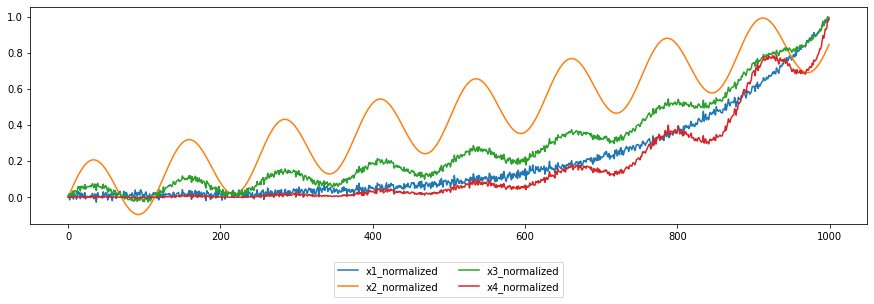

In [3]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8


# normalize per time series
x1_normalized = x1 / np.ceil(np.max(np.abs(x1)))
x2_normalized = x2 / np.ceil(np.max(np.abs(x2)))
x3_normalized = x3 / np.ceil(np.max(np.abs(x3)))
x4_normalized = x4 / np.ceil(np.max(np.abs(x4)))


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

(981, 2, 20)


'\nwith open(text_file) as f:\n    lines = f.read().split("\n")[:-1]\ntext_pairs = []\nfor line in lines:\n    eng, spa = line.split("\t")\n    spa = "[start] " + spa + " [end]"\n    text_pairs.append((eng, spa))\n'

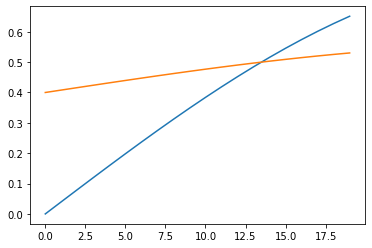

In [4]:
# generate pairs 
surrogate_data = np.array([x5,x5*0.2+0.4]).T
surrogate_pairs = create_rolling_windows(surrogate_data,20)
surrogate_pairs = np.swapaxes(surrogate_pairs,1,2)
print(surrogate_pairs.shape)

plt.plot(surrogate_pairs[0][0])
plt.plot(surrogate_pairs[0][1])

'''
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))
'''

In [5]:
for _ in range(5):
    print(random.choice(surrogate_pairs))

[[-0.37036245 -0.40537465 -0.4393716  -0.47226815 -0.50398191 -0.53443346
  -0.56354652 -0.5912482  -0.6174691  -0.64214356 -0.66520977 -0.68660999
  -0.70629059 -0.72420231 -0.74030027 -0.75454416 -0.7668983  -0.77733177
  -0.78581841 -0.79233699]
 [ 0.32592751  0.31892507  0.31212568  0.30554637  0.29920362  0.29311331
   0.2872907   0.28175036  0.27650618  0.27157129  0.26695805  0.262678
   0.25874188  0.25515954  0.25193995  0.24909117  0.24662034  0.24453365
   0.24283632  0.2415326 ]]
[[0.79054582 0.79569078 0.79884294 0.79999441 0.7991423  0.79628876
  0.79144092 0.78461093 0.77581589 0.76507784 0.75242366 0.73788505
  0.72149841 0.7033048  0.68334976 0.66168329 0.63835965 0.61343724
  0.58697848 0.55904965]
 [0.55810916 0.55913816 0.55976859 0.55999888 0.55982846 0.55925775
  0.55828818 0.55692219 0.55516318 0.55301557 0.55048473 0.54757701
  0.54429968 0.54066096 0.53666995 0.53233666 0.52767193 0.52268745
  0.5173957  0.51180993]]
[[0.13191876 0.17122899 0.21011038 0.2484655

In [6]:
random.shuffle(surrogate_pairs)
num_val_samples = int(0.15 * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

'''
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")
'''

981 total pairs
687 training pairs
147 validation pairs
147 test pairs


'\nrandom.shuffle(text_pairs)\nnum_val_samples = int(0.15 * len(text_pairs))\nnum_train_samples = len(text_pairs) - 2 * num_val_samples\ntrain_pairs = text_pairs[:num_train_samples]\nval_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]\ntest_pairs = text_pairs[num_train_samples + num_val_samples :]\n\nprint(f"{len(text_pairs)} total pairs")\nprint(f"{len(train_pairs)} training pairs")\nprint(f"{len(val_pairs)} validation pairs")\nprint(f"{len(test_pairs)} test pairs")\n'

In [33]:

train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))

batch_size = 64
sequence_length = 20
vocab_size = 15000

'''
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)
'''

(687, 20)
(687, 20)


'\nstrip_chars = string.punctuation + "¿"\nstrip_chars = strip_chars.replace("[", "")\nstrip_chars = strip_chars.replace("]", "")\n\nvocab_size = 15000\nsequence_length = 20\nbatch_size = 64\n\n\ndef custom_standardization(input_string):\n    lowercase = tf.strings.lower(input_string)\n    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")\n\n\neng_vectorization = TextVectorization(\n    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,\n)\nspa_vectorization = TextVectorization(\n    max_tokens=vocab_size,\n    output_mode="int",\n    output_sequence_length=sequence_length + 1,\n    standardize=custom_standardization,\n)\ntrain_eng_texts = [pair[0] for pair in train_pairs]\ntrain_spa_texts = [pair[1] for pair in train_pairs]\neng_vectorization.adapt(train_eng_texts)\nspa_vectorization.adapt(train_spa_texts)\n'

In [34]:

def make_dataset(pairs):
    input_seq, target_seq = zip(*pairs)
    input_seq = list(input_seq)
    target_seq = list(target_seq)
    dataset = tf.data.Dataset.from_tensor_slices((input_seq, target_seq))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    print(dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

def format_dataset(inp, target):
    #inp = inp_vectorization(inp)
    #target = target_vectorization(target)
    print(np.shape(inp))
    print(np.shape(target))
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target[:, 1:]) # why these indices for target?
    return ({"encoder_inputs": inp, "decoder_inputs": target}, target)


'''
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()
'''

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

(None, 20)
(None, 20)
<MapDataset shapes: ({encoder_inputs: (None, 20), decoder_inputs: (None, 20)}, (None, 20)), types: ({encoder_inputs: tf.float64, decoder_inputs: tf.float64}, tf.float64)>
(None, 20)
(None, 20)
<MapDataset shapes: ({encoder_inputs: (None, 20), decoder_inputs: (None, 20)}, (None, 20)), types: ({encoder_inputs: tf.float64, decoder_inputs: tf.float64}, tf.float64)>


In [35]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [36]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [40]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="float64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="float64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
'''
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
'''

'\nembed_dim = 256\nlatent_dim = 2048\nnum_heads = 8\n\nencoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")\nx = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)\nencoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)\nencoder = keras.Model(encoder_inputs, encoder_outputs)\n\ndecoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")\nencoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")\nx = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)\nx = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)\nx = layers.Dropout(0.5)(x)\ndecoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)\ndecoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)\n\ndecoder_outputs = decoder([decoder_inputs, encoder_outputs])\ntransformer = keras.Model(\n    [encoder_inputs, decoder_inputs], decoder_o

In [41]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_2 (Positio (None, None, 256)    3845120     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_1 (Transfor (None, None, 256)    3155456     positional_embedding_2[0][0]     
________________________________________________________________________________________

In [39]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

NameError: name 'spa_vectorization' is not defined